You own a bike store. During week $t$, the (random) demand is $D_t$ units. 
On Monday morning you may choose to command $A_t$ additional units: they are delivered immediately before the shop opens. For each week:

  * Maintenance cost: $h$ per unit in stock left from the previous week (no maintenance is needed for newly commanded items)
  * Command cost: $c$ for each unit ordered + $c_0$ per command
  * Sales profit: $p$ per unit sold
  * Constraint: 
    - your warehouse has a maximal capacity of $M$ unit (any additionnal bike gets stolen)
    - you cannot sell bikes that you don't have in stock


* State: number of bikes in stock left from the last week => state space $\mathcal{S} = \{0,\dots, M\}$
* Action: number of bikes commanded at the beginning of the week => action space $\mathcal{A} = \{0, \dots ,M\}$ 
* Reward = balance of the week: if you command $a_t$ bikes,
$$r_t = -c_0 \mathbb{1}_{(a_t >0)}- c \times a_t - h\times s_t + p \times \min(D_t, s_t+a_t, M)$$
* Transitions: you end the week with the number of bikes $$s_{t+1} = \max\big(0, \min(M, s_t + a_t)  - D_t \big)$$ 

Our goal is to maximize the discounted sum of rewards, starting from an initial stock $s_1$, that is to find a policy whose value is 
$$V^*(s_1) = \max_{\pi}\mathbb{E}_{\pi}\left[\sum_{s=1}^{\infty} \gamma^{s-1}r_s \right].$$

In [3]:
import numpy as np
import random as rd
import gym
from matplotlib import pyplot as plt
import time 

### Problem parameters 

In [11]:
M = 15 # stock capacity
h = 0.3 # maintenance cost (per unit)
c = 0.5 # ordering cost (per unit)
c0 = 0.3 # fix delivery cost per command
p = 1 # selling price (per unit)

### Specifying the demand distribution 

We choose a (truncated) geometric distribution, for which 
$$\mathbb{P}(D_t = m) = q(1-q)^m \ \ \forall m \in \{0,\dots,M-1\}$$
and $\mathbb{P}(D_t = M) = 1 - \sum_{m=0}^{M-1}\mathbb{P}(D_t = m)$. 

In [12]:
# demand distribution (truncated geometric with parameter q)
q = 0.1
pdem = np.array([q*(1-q)**m for m in range(M+1)])
pdem[M] = pdem[M]+1-np.sum(pdem)

print("the average demand is ",np.sum([m*pdem[m] for m in range(M+1)]))

def SimuDemand(pdem): 
    cpdem = np.cumsum(pdem)
    i=0
    u = rd.random()
    while (u >cpdem[i]):
        i = i+1
    return i 

print("a simulated demand is ",SimuDemand(pdem))

the average demand is  7.1469798111481575
a simulated demand is  0


### Encoding of the MDP as a gym-like environment


In [13]:
def nextstate(s,a,d,M):
    # computes the next state if the demand is d
    return max(0,min(M,s+a) -d)

def nextreward(s,a,d,M,c,c0,h,p):
    # computes the reward if the demand is d
    rew = -c*a - h*s + p*min(M,d,s+a)
    if (a>0):
        rew = rew - c0
    return rew

class StoreManagement(gym.Env):
    """
    Retail Store Management environment
    The environment defines which actions can be taken at which point and
    when the agent receives which reward.
    """
    def __init__(self,FirstState):
        
        # General variables defining the environment
        self.Stock_Capacity = M
        self.Maintenance_Cost = h
        self.Order_Cost = c 
        self.Delivery_Cost = c0
        self.Selling_Price = p
        self.Demand_Distribution = pdem
        
        # Define the action space
        self.action_space = gym.spaces.Discrete(self.Stock_Capacity+1)

        # Define the state space (state space = observation space in this example)
        self.observation_space = gym.spaces.Discrete(self.Stock_Capacity+1)

        # current time step
        self.curr_step = -1 # 
        
        # initial state
        self.state = FirstState

    def step(self, action):
        """
        simulates a transition following an action in the current state
        action : int
        """
        self.curr_step += 1
        # simulate the demand 
        Demand = SimuDemand(self.Demand_Distribution)
        # compute the reward
        reward = nextreward(self.state,action,Demand,self.Stock_Capacity,self.Order_Cost,self.Delivery_Cost,self.Maintenance_Cost,self.Selling_Price)
        # compute the next state 
        self.state = nextstate(self.state,action,Demand,self.Stock_Capacity)
        # return 4 elements: observation / reward / termination? (no terminal state here) / information (optional) 
        return self.state, reward, False, {}

    def reset(self,InitialStock):
        """
        Reset the state of the environment and returns an initial observation.
        """
        self.curr_step = -1
        self.state = InitialStock
    
    def _render(self, mode='human'):
        """optional visualization of the interaction: none here"""
        return


### Simulating trajectories

Here are three simple examples of (stationary) policies that are functions mapping states to actions. 

In [18]:
def PiUniform(s):
    # pick uniformly at random in {0,1,...,M-s}
    x = rd.sample(range(M+1-s),1)
    return s+x[0]

def PiConstant(s,c=3):
    # oder a constant number of c bikes 
    return min(c,M-s)

def PiThreshold(s,m1=4,m2=10):
    # if less than m1 bikes in stock, refill it up to m2
    action = 0
    if (s <=m1):
        action = (m2-s)
    return action

**Complete the function below to simulate a trajectory of length $T$ from an initial state $s_0$ under a policy Pi**

In [19]:
env=StoreManagement(0)

def SimulateTrajectory(T,Pi,s0):
    """return a vector of T successive states and a vector of T successive rewards"""
    Rewards = np.zeros(T+1)
    States = np.zeros(T+1)
    env.reset(s0)
    for t in range(T):
        States[t]= ### TO BE COMPLETED
        Rewards[t]= ### TO BE COMPLETED
    return States,Rewards

SyntaxError: invalid syntax (1191612869.py, line 9)

### Running simulations with our three simple baselines 

**Plot the cumulative discounted reward as a function of time for the three baselines.**

In [20]:
s1 = 10 # initial stock 
gamma = 0.97 # discount factor 

T = int(np.log(1/(0.001*(1-gamma)))/np.log(1/gamma)) # truncation of the infinite sum

States1,Rewards1 = SimulateTrajectory(T, PiUniform,s1)
States2,Rewards2 = SimulateTrajectory(T, PiConstant,s1)
States3,Rewards3 = SimulateTrajectory(T, PiThreshold,s1)



### Evolution of the stock

In [21]:
plt.figure()
plt.plot(States3[range(100)])
plt.xlabel('weeks')
plt.ylabel('stock')
plt.title('Evolution of the stock under a threshold policy')

Text(0.5, 1.0, 'Evolution of the stock under a threshold policy')

# Dynamic Programming

Here we assume that we work on a *known* MDP: that is, we know the demand distribution hence we are able to compute the parameters of the MDP: the transition kernel and the average reward

## Computing the parameters of the MDP

Using the characteristics of the demand distributions, we are able to compute the expected rewards $r(s,a)$ and the transition probabilities $p(s'|s,a)$ for all states and actions. 

In [10]:
# MDP parameters
P = np.zeros((M+1,M+1,M+1)) # P[s,a,s'] = p(s' | s,a) 
r = np.zeros((M+1,M+1)) # r[s,a] = average reward received in state s when playing action a

## computation: iterate over all possible states, actions, and possible demand values
for a in range(M+1):
    for s in range(M+1):
        for d in range(M+1):
            # next state and reward with demand d
            ns = max(0,min(M,s+a) -d)
            reward = -c*a - h*s+p*min(M,d,s+a)
            if (a>0):
                reward = reward - c0
            P[s,a,ns] += pdem[d]
            r[s,a] += pdem[d] * reward

## Evaluation of deterministic policies

**Evaluate a policy of your choice using Monte-Carlo simulation, i.e. compute the value of this policy in all states.** 

Observe that we do not need the knowledge of $P$ and $r$ for this method, we only need to be able to simulate trajectories.  

**Implement a function that evaluates a policy Pi using the matrix inversion technique seen in class. Compare the output with the previous method for the same policy.**

Unlike the previous evaluation method, this one requires the knowledge of $P$ and $r$. 

In [22]:
def EvaluatePolicy(Pi):
    ## TO BE COMPLETED 
    return V[0]

Policy=PiThreshold
Values = EvaluatePolicy(Policy)

print(Values)    

NameError: name 'V' is not defined

Evaluate two different policies and visualize their values for the different states in order to decide which one is better. 

In [23]:
Values1 = EvaluatePolicy(PiConstant)
Values2 = EvaluatePolicy(PiThreshold)

plt.plot(Values1,label ="Constant policy c=3")
plt.plot(Values2,label = "Threshold policy m1=4, m2=10")
plt.xlabel('stock')
plt.ylabel('value ')
plt.legend()
plt.title('Values of two different policies')


NameError: name 'V' is not defined

## Computing the Optimal Policy: Policy Iteration 


In [14]:
# policy improvement
def Improve(V):
    '''returns the greedy policy wrt to V'''
    Pi = np.zeros(M+1) # improved policy 
    newV = np.zeros(M+1)
    # compute the Q table 
    Q = np.zeros((M+1,M+1))
    for s in range(M+1):
        for a in range(M+1):
            Q[s,a]=avgR[s,a]+gamma*np.sum([K[s,ns,a]*V[ns] for ns in range(M+1)])
        # improvement (greedy policy wrt to Q)
        pi = np.argmax(Q[s,:])
        Pi[s]=pi
        newV[s]=Q[s,pi]
        Pi=Pi.astype(int)
    return Pi


**Implement Policy Iteration**

In [24]:
def PolicyIteration():
    pass
    return Pi,V,nIt
        
start = time.time()
Pi,V,nIt = PolicyIteration()
elapsed = time.time()-start

print("Optimal policy is",Pi,"with value ",V," in ",nIt," iterations and t=",elapsed," seconds")


NameError: name 'Pi' is not defined

Display the optimal policy and optimal value function. 

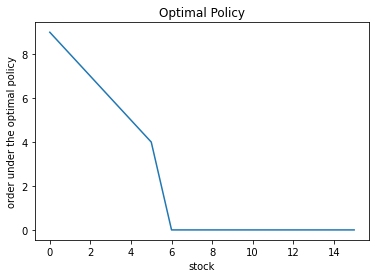

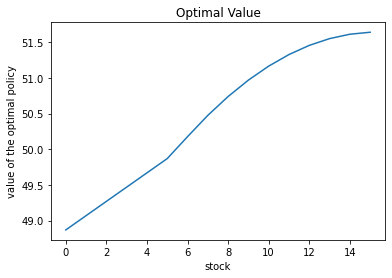

In [16]:
plt.plot(Pi)
plt.xlabel('stock')
plt.ylabel('order under the optimal policy')
plt.title("Optimal Policy")

plt.figure()
plt.plot(V)
plt.xlabel('stock')
plt.ylabel('value of the optimal policy')
plt.title("Optimal Value")

Vstar=np.copy(V)

# Temporal Difference Methods

Now are are back to reinforcement learning algorithms, who cannot make use of the knowledge of $P$ and $r$, but can only simulate transistions. 

## Stochastic Approximation for Policy Evaluation: TD(0)

In [17]:
def TD0(Pi, T):
    V = np.random.rand(M+1) # V[s] = estimated value of each state under policy pi
    N = np.zeros(M+1) # N[s] =number of visits to state s in the loop
    s0 = np.random.randint(M+1)
    env=StoreManagement(s0)
    for t in range(T):
        S = env.state
        N[S] += 1
        action = Pi(S)
        nS,rew,x,y = env.step(action) 
        alpha = 1/((1+N[S])**0.5) 
        V[S] = (1-alpha)*V[S] + alpha * (rew + gamma*V[nS]) 
    return(V)

T = 10**7
start=time.time()
print("value computed by TD0 ",TD0(PiConstant, T))
print("time elapsed is",time.time()-start,"\n")
print("value computed by matrix inversion",Values)
# requires a large number of iterations to converge... at least 10^7

## slightly less slow without gym (1s for 10^6) but not critical

value computed by TD0  [29.621279   30.13404741 30.57815978 30.93297905 31.34938973 31.52351507
 31.72965068 32.06798314 32.00752086 32.62899396 32.36627833 32.59880564
 33.03932569 32.74207196 33.12227287 32.76769027]
time elapsed is 82.8329164981842 

value computed by matrix inversion [48.73499347 48.93499347 49.13499347 49.33499347 49.53499347 49.71122352
 50.04440882 50.34326461 50.60790492 50.83844345 51.03499347 51.19766791
 51.32657931 51.42183984 51.48356131 51.51185512]


## Q-Learning

In [18]:
def QLearning(Landmarks):
    star=time.time()
    nbLands = len(Landmarks)
    # random initialization of the Q table
    Q = 10*np.random.rand(1+M, 1+M) 
    N = np.zeros((M+1,M+1)) # number of visits to state-values 
    epsilon = 0.3
    s0 = np.random.randint(M+1)
    env=StoreManagement(s0)
    for k in range(nbLands-1):       
        for t in range(Landmarks[k]+1,Landmarks[k+1]):
            S=env.state
            A =np.random.randint(M+1)
            if (rd.random()>epsilon):# epsilon-greedy choice of action
                 A = np.argmax(Q[S, :]) # greedy action           
            N[S,A] += 1
            nS,rew,x,y = env.step(A)
            delta = rew + gamma * max(Q[nS, :]) - Q[S,A]
            alpha = 1/((1+N[S,A])**0.5)
            Q[S, A] += alpha * delta
        # compute the greedy policy 
        Pi = np.array([np.argmax(Q[s,:]) for s in range(M+1)])
        Pi = Pi.astype(int)
        print("After T=",Landmarks[k+1],"iterations (",np.floor(time.time()-start),"seconds), the policy is",Pi)
    return Pi,Q

Landmarks = np.array([0,10**3,10**4,10**5,10**6,10**7])
Pi,Q = QLearning(Landmarks)

# for T >= 10^7, we obtain correct policies
# for T >= 10^8, we almost obtain the right one

After T= 1000 iterations ( 121.0 seconds), the policy is [ 9  7  3  9  0  5  1  4  2  2  4  4 14  4  5  4]
After T= 10000 iterations ( 121.0 seconds), the policy is [9 5 5 0 0 2 1 0 3 3 2 3 1 1 0 2]
After T= 100000 iterations ( 124.0 seconds), the policy is [ 8 15  9  8  0  4  0  0  0  0  0  0  0  1  0  2]
After T= 1000000 iterations ( 154.0 seconds), the policy is [8 9 6 6 7 5 0 0 0 0 0 0 0 0 0 0]
After T= 10000000 iterations ( 428.0 seconds), the policy is [9 8 8 7 5 0 0 0 0 0 0 0 0 0 0 0]


Q-Learning is extremely slow to converge. In practice, as a retail store manager, you could obviously do something smarter :). Leveraging your knowledge that the optimal policy will be a threshold policy, you could for example run a bandit strategy on a well chosen finite set of reasonnable thresholds. Or just estimate the demand and therefore the parameters of the MDP (model-based approach).   